In [70]:
#from tensorflow_docs.vis import embed
from tensorflow import keras
#from imutils import paths

import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
#import imageio
import cv2
import os
import json
from ipywidgets import Video, Image

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [71]:
#Prevent tensorflow to allocate the entire GPU
#https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [72]:
# train_df= pd.read_csv('/home/app/src/data/CSV/dataset_train_v2+v3.csv', )
# test_df= pd.read_csv('/home/app/src/data/CSV/dataset_test_v3.csv', )

In [73]:
train_df= pd.read_csv('/home/app/src/CSV/dataset_train_v2+v3_with_rep_shuffle.csv')
test_df= pd.read_csv('/home/app/src/CSV/dataset_test_v2+v3_with_rep_shuffle.csv')

In [74]:
# train_df = train_df.drop(columns =['tag','Unnamed: 0'])
# train_df = train_df.rename(columns ={'move_label':'tag'})

In [75]:
train_df

,video_name,tag
0,/home/app/src/data/shot-type-dataset/trailer_v...,Pull
1,/home/app/src/data/shot-type-dataset/trailer_v...,Pull
2,/home/app/src/data/shot-type-dataset/trailer_v...,Push
3,/home/app/src/data/shot-type-dataset/trailer_v...,Static
4,/home/app/src/data/shot-type-dataset/trailer_v...,Push
...,...,...
1185,/home/app/src/data/shot-type-dataset/trailer_v...,Static
1186,/home/app/src/data/shot-type-dataset/trailer_v...,Push
1187,/home/app/src/data/shot-type-dataset/trailer_v...,Pull
1188,/home/app/src/data/shot-type-dataset/trailer_v...,Push


In [76]:
# test_df = test_df.drop(columns =['tag','Unnamed: 0'])
# test_df = test_df.rename(columns ={'move_label':'tag'})

In [77]:
test_df

,video_name,tag
0,/home/app/src/data/shot-type-dataset/trailer_v...,Static
1,/home/app/src/data/shot-type-dataset/trailer_v...,Pull
2,/home/app/src/data/shot-type-dataset/trailer_v...,Motion
3,/home/app/src/data/shot-type-dataset/trailer_v...,Motion
4,/home/app/src/data/shot-type-dataset/trailer_v...,Motion
...,...,...
315,/home/app/src/data/shot-type-dataset/trailer_v...,Motion
316,/home/app/src/data/shot-type-dataset/trailer_v...,Static
317,/home/app/src/data/shot-type-dataset/trailer_v...,Push
318,/home/app/src/data/shot-type-dataset/trailer_v...,Push


Checking correct video tagging with original JSON

In [78]:
# # reading the JSON data using json.load()
# json_path = '/home/app/src/data/shot-type-dataset/v1_split_trailer.json'
# json_v2_path = '/home/app/src/data/shot-type-dataset/v2_full_trailer.json'

# with open(json_path) as train_file:
#     dict_v1= json.load(train_file)
# with open(json_v2_path) as v2_file:
#     dict_v2= json.load(v2_file)


# def tag_ckecker (df, json_dict1, json_dict2, df_name_to_check):
#     tag_chek_list = []

#     for i in range(len(df.index)):
#         movie = df['video_name'][i]
#         df_tag = df['tag'][df['video_name'] == movie][i]
#         find_char_st = movie.find('_', 55,60)
#         find_char_end = movie.find('_', 65,70)
#         movie_key = movie[find_char_st+1:find_char_end]
#         trailer_key =  movie[find_char_end+1:find_char_end+5]
#         try:
#             dict_tag = json_dict1[df_name_to_check][movie_key][trailer_key]['movement']['label']
#         except KeyError:
#             try:
#                 dict_tag = json_dict1['val'][movie_key][trailer_key]['movement']['label']
#                 if dict_tag == df_tag:
#                     pass
#                 else:
#                     tag_chek_list.append(movie)
#             except KeyError:
#                 dict_tag = json_dict2[movie_key][trailer_key]['movement']['label']
#                 if dict_tag == df_tag:
#                     pass
#                 else:
#                     tag_chek_list.append(movie)

            

#     if len(tag_chek_list) == 0:
#         print(f'tag check {df_name_to_check} OK')
#     else: print (tag_chek_list)


# tag_ckecker(train_df, dict_v1, dict_v2, 'train')
# tag_ckecker(test_df, dict_v1, dict_v2, 'test')


In [79]:
print(f'Train value counts:' '\n',train_df['tag'].value_counts(), '\n')
print(f'Test value counts:' '\n',test_df['tag'].value_counts(), '\n')


Train value counts:
 Static    320
Motion    320
Push      303
Pull      247
Name: tag, dtype: int64 

Test value counts:
 Static    80
Pull      80
Motion    80
Push      80
Name: tag, dtype: int64 



Define hyperparameters

In [80]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20

MAX_SEQ_LENGTH = 40
NUM_FEATURES = 2048

Loading frames and working on frame's size

In [81]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

Feature extractor

In [82]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
print(feature_extractor.summary())

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________
None


Working on labels

In [83]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['Motion', 'Pull', 'Push', 'Static']


Preparing videos

In [84]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        print(f' {root_dir}_video {idx}/{len(video_paths)} done')

    return (frame_features, frame_masks), labels


#train_data, train_labels = prepare_all_videos(train_df, "train")
#print(f"Frame features in train set: {train_data[0].shape}")


Saving TRAIN embeddings

In [85]:
# path_save_embeddings= '/home/app/src/embeddings/emb_v2+v3_with_rep_shuffle_40F/'

# # Train
# train_data_embedding_0 = np.save(path_save_embeddings + 'train_data_embedding_0.npy', train_data[0])
# train_data_embedding_1 = np.save(path_save_embeddings + 'train_data_embedding_1.npy', train_data[1])
# train_labels_embedding = np.save(path_save_embeddings + 'train_labels_embedding.npy', train_labels)

Preparing TEST videos

In [86]:
# test_data, test_labels = prepare_all_videos(test_df, "test")
# print(f"Frame masks in test set: {test_data[1].shape}")

Saving TEST embeddings

In [87]:
# #Test
# test_data_embedding_0 = np.save(path_save_embeddings + 'test_data_embedding_0.npy', test_data[0])
# test_data_embedding_1 = np.save(path_save_embeddings + 'test_data_embedding_1.npy', test_data[1])
# test_labels_embedding = np.save(path_save_embeddings + 'test_labels_embedding.npy', test_labels)

Loading embeddings

In [89]:
path_load_embeddings= '/home/app/src/embeddings/move_shot/emb_v2+v3_with_rep_shuffle_40F/'

#Train
train_data_0 = np.load(path_load_embeddings + 'train_data_embedding_0.npy')
train_data_1 = np.load(path_load_embeddings + 'train_data_embedding_1.npy')
train_data=(train_data_0, train_data_1)
train_labels = np.load(path_load_embeddings + 'train_labels_embedding.npy')

#Test
test_data_0 = np.load(path_load_embeddings + 'test_data_embedding_0.npy')
test_data_1 = np.load(path_load_embeddings + 'test_data_embedding_1.npy')
test_data=(test_data_0, test_data_1)
test_labels = np.load(path_load_embeddings + 'test_labels_embedding.npy')

In [90]:
train_data_0.shape

(1190, 40, 2048)

In [91]:
test_data_0.shape

(320, 40, 2048)

In [92]:
# path_load_labels= '/home/app/src/embeddings/aa/'
# train_labels = np.load(path_load_labels + 'train_labels_embedding.npy')
# test_labels = np.load(path_load_labels + 'test_labels_embedding.npy')


Sequence model (RNN)

In [106]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(20, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(10)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(10, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab),kernel_regularizer='l2', activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"],
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/home/app/src/experiments/inceptionv3_GRU/exp_006/model.weights_exp_005.h5"
    filepath_log = '/home/app/src/experiments/inceptionv3_GRU/logs/logs'

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1)
    tensor_board = keras.callbacks.TensorBoard (filepath_log)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint, reduce_lr, tensor_board],
        batch_size = BATCH_SIZE,
        shuffle = True
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # Getting predictions
    y_pred_proba = seq_model.predict([test_data[0], test_data[1]])
    y_pred = []   
    for arr in y_pred_proba:
        idx_max = np.argmax(arr)
        y_pred.append(idx_max)

    return history, seq_model, y_pred, y_pred_proba


_, sequence_model, y_pred, y_pred_proba = run_experiment()


Epoch 1/20
13/14 [==========================>...] - ETA: 0s - loss: 1.4311 - accuracy: 0.2452
Epoch 1: val_loss improved from inf to 1.41897, saving model to /home/app/src/experiments/inceptionv3_GRU/exp_006/model.weights_exp_005.h5
14/14 [==============================] - 12s 268ms/step - loss: 1.4311 - accuracy: 0.2449 - val_loss: 1.4190 - val_accuracy: 0.2941 - lr: 0.0010
Epoch 2/20
13/14 [==========================>...] - ETA: 0s - loss: 1.4174 - accuracy: 0.2668
Epoch 2: val_loss improved from 1.41897 to 1.41391, saving model to /home/app/src/experiments/inceptionv3_GRU/exp_006/model.weights_exp_005.h5
14/14 [==============================] - 1s 42ms/step - loss: 1.4174 - accuracy: 0.2665 - val_loss: 1.4139 - val_accuracy: 0.3053 - lr: 0.0010
Epoch 3/20
13/14 [==========================>...] - ETA: 0s - loss: 1.4232 - accuracy: 0.2620
Epoch 3: val_loss did not improve from 1.41391
14/14 [==============================] - 1s 43ms/step - loss: 1.4231 - accuracy: 0.2629 - val_loss: 1

In [107]:
%tensorboard == logdir /home/app/src/experiments/inceptionv3_GRU/logs

UsageError: Line magic function `%tensorboard` not found.


In [115]:
y_pred_proba #predictions proba

array([[0.27599987, 0.20590512, 0.25338924, 0.26470575],
       [0.25489923, 0.22379419, 0.2621644 , 0.2591422 ],
       [0.27522898, 0.20703451, 0.25321335, 0.26452318],
       ...,
       [0.26727453, 0.21494207, 0.25525337, 0.26253003],
       [0.25318488, 0.21924049, 0.26954722, 0.2580274 ],
       [0.24706602, 0.23786521, 0.26634184, 0.24872693]], dtype=float32)

In [108]:
class_vocab = label_processor.get_vocabulary()
class_vocab

['Motion', 'Pull', 'Push', 'Static']

In [109]:
np.unique(y_pred)   # predictions

array([0, 2, 3])

In [110]:
np.unique(test_labels) # True labels

array([0, 1, 2, 3])

<AxesSubplot: >

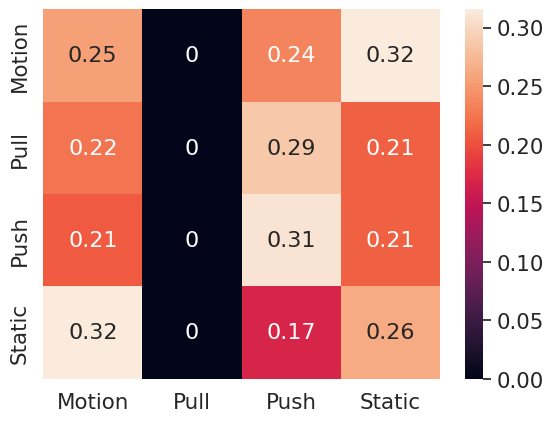

In [111]:
# Confussion Matrix
c_matrix = confusion_matrix(test_labels, y_pred , normalize='pred')
# Plotting
class_vocab = label_processor.get_vocabulary()
df_cm = pd.DataFrame(c_matrix,index = [i for i in class_vocab],
                  columns = [i for i in class_vocab])
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size


In [112]:
# Metrics report
class_vocab = label_processor.get_vocabulary()
print(classification_report(test_labels, y_pred, target_names=class_vocab ))

              precision    recall  f1-score   support

      Motion       0.25      0.53      0.34        80
        Pull       0.00      0.00      0.00        80
        Push       0.31      0.53      0.39        80
      Static       0.26      0.06      0.10        80

    accuracy                           0.28       320
   macro avg       0.21      0.28      0.21       320
weighted avg       0.21      0.28      0.21       320



/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
#[precision, recall,f1,support]=precision_recall_fscore_support(y_true, y_pred, average='macro')

Predictions

In [114]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
real_label = test_df[test_df['video_name'] ==test_video]['tag'].iloc[0]
print(f'Real Label: {real_label}')
new_ = Video.from_file(test_video,play=True)
new_
#to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: /home/app/src/data/shot-type-dataset/trailer_v3/test/shot_tt2467442_0039.mp4
  Motion: 26.27%
  Static: 26.13%
  Push: 25.81%
  Pull: 21.79%
Real Label: Pull


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')